# 📄 Document Content Generator Workflow

## 📌 Overview

In this workflow, we build a **document content generator** that:
- Takes a **topic** as input
- Generates content using an LLM
- Evaluates whether the content is approved
- Regenerates content if approval fails

This loop continues until the content is approved.

---

In [2]:
## llm used 
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model='llama3.2',
    verbose=True,
    temperature=0
)

llm.invoke("Hello How are you?")

AIMessage(content="I'm just a language model, so I don't have emotions or feelings like humans do. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2026-01-08T13:47:31.16166Z', 'done': True, 'done_reason': 'stop', 'total_duration': 12137360833, 'load_duration': 180077833, 'prompt_eval_count': 30, 'prompt_eval_duration': 8130627500, 'eval_count': 47, 'eval_duration': 3823498333, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'}, id='lc_run--019b9ddc-9a62-7461-96d8-8786bb858fe9-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 30, 'output_tokens': 47, 'total_tokens': 77})

---

In [6]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal 

In [20]:
# Graph State for content creation 
class ContentState(TypedDict):
    topic: str 
    content: str 
    evaluator_status: Literal['is_approved', 'needs_improvement']
    evaluator_feedback: str 
    iteration: int 
    max_iteration: int  

In [21]:
# Data Validation class for Evaluator LLM 
from pydantic import BaseModel, Field
from typing import Annotated

class EvaluateContent(BaseModel):
    evaluator_status: Annotated[Literal['is_approved', 'needs_improvement'], Field(description="Is the post good enough for posting on social media, or it need to be improved")]
    evaluator_feedback: Annotated[str, Field(description="Short Feedback of evaluated post.")]

In [31]:
from langchain_core.prompts import PromptTemplate 

def generate_content(state: ContentState) -> ContentState:
    template = """
                You are a helpful content generator who is given with the topic : {topic}.
                Generate a short Post related to the given topic. 
               """

    prompt = PromptTemplate(
        template=template,
        input_variables=['topic']
    )

    chain = prompt | llm 
    response = chain.invoke({'topic' : state['topic']})
    print(f"Iteration : {state['iteration']}")
    print(f"Content : {response.content}")
    return {
        **state,
        'content' : response.content
    }


def evaluate_content(state: ContentState) -> ContentState:
    template = """
                You are a helpful evaluator. Give the content : {content} for post on topic : {topic}.
                You need to evaluate whether generated content is approved for Post or it need to be improved.
               """

    prompt = PromptTemplate(
        template=template,
        input_variables=['topic', 'content']
    )

    llm_evaluator = llm.with_structured_output(EvaluateContent)

    chain = prompt | llm_evaluator 
    response = chain.invoke({'topic' : state['topic'], 'content' : state['content']})
    print(f"Evaluator Status : {response.evaluator_status}")
    print("-"*89)
    return {
        **state,
        'evaluator_status' : response.evaluator_status,
        'evaluator_feedback' : response.evaluator_feedback
    }

def optimize_content(state: ContentState) -> ContentState:
    template = """
                You are helpful assistant who was given with a topic : {topic}, content : {content}, its feedback : {feedback}.
                On the basis of feedback you need to generate new content on that topic with improved results. 
               """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['topic', 'content', 'feedback']
    )

    chain = prompt | llm 
    response = chain.invoke({'topic' : state['topic'], 'content' : state['content'], 'feedback' : state['evaluator_feedback']})
    return {
        **state,
        'content' : response.content,
        'iteration' : state['iteration'] + 1
    }

def check_for_iteration(state: ContentState) -> Literal['is_approved', 'needs_improvement']:
    if state['iteration'] > state['max_iteration'] or state['evaluator_status'] == 'is_approved':
            return 'is_approved'
    else:
        return 'needs_improvement'

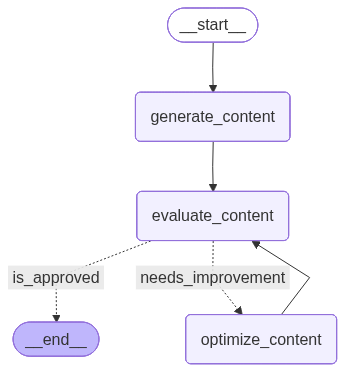

In [32]:
graph = StateGraph(ContentState)

# add nodes 
graph.add_node('generate_content', generate_content)
graph.add_node('evaluate_content', evaluate_content)
graph.add_node('optimize_content', optimize_content)

# add edges 
graph.add_edge(START, 'generate_content')
graph.add_edge('generate_content', 'evaluate_content')
graph.add_edge('optimize_content', 'evaluate_content')
graph.add_conditional_edges('evaluate_content', check_for_iteration, {'is_approved' : END, 'needs_improvement' : 'optimize_content'})

# compile graph 
content_generator = graph.compile()

# display graph 
from IPython.display import Image 
Image(content_generator.get_graph().draw_mermaid_png())

In [33]:
input_state = {'topic' : 'LLMs and Attention', 'iteration' : 1, 'max_iteration' : 3}
output_state = content_generator.invoke(input_state)

Iteration : 1
Content : **Understanding LLMs and Attention Mechanisms**

Large Language Models (LLMs) have revolutionized the field of natural language processing (NLP) in recent years. One key component that enables these models to understand and generate human-like text is the attention mechanism.

**What is Attention?**

Attention is a fundamental concept in deep learning that allows a model to focus on specific parts of an input when generating output. In the context of LLMs, attention is used to weigh the importance of different words or tokens in a sentence when predicting the next word.

**How does Attention work in LLMs?**

The attention mechanism works by computing a weighted sum of the input tokens based on their relevance to the target token. This is achieved through a set of learnable weights, known as attention weights, which are computed using a neural network. The attention weights are then used to compute a weighted sum of the input tokens, which is passed through a lin

In [34]:
from pprint import pprint 
pprint(output_state)

{'content': '**Unlocking the Power of Attention in Large Language Models: A '
            'Comprehensive Guide**\n'
            '\n'
            'Attention mechanisms have revolutionized the field of natural '
            'language processing (NLP), enabling Large Language Models (LLMs) '
            'to understand and generate human-like text with unprecedented '
            'accuracy. In this article, we will delve into the world of '
            'attention mechanisms, exploring their importance, types, '
            'benefits, and real-world applications in LLMs.\n'
            '\n'
            '**The Importance of Attention Mechanisms**\n'
            '\n'
            'Attention mechanisms are a crucial component of LLMs, allowing '
            'them to selectively focus on specific parts of an input when '
            'generating output. This process enables LLMs to improve their '
            'performance, reduce overfitting, and increase interpretability. '
            'By under